#### iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv에서 2개 Feature 사용
- 구현프레임워크 : Pytorch

[1] 모듈 로딩 및 데이터 준비

In [1]:
# 모듈 로딩
import torch                        # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn               # 인공신경망 관련 모듈
import torch.nn.functional as F     # 손실, 거리 등 함수 관련 모듈
import torch.optim as optimizer     # 최적화 기법 관련 모듈

import pandas as pd                 # 데이터 파일 분석 관련 모듈
from sklearn.model_selection import train_test_split

In [2]:
torch.manual_seed(1)

In [3]:
# 데이터 로딩 : csv => DataFrame
DATA_FILE = '../Data/iris.csv'

irisDF = pd.read_csv(DATA_FILE, usecols=[0, 1, 2, 3])

In [4]:
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


[2] 모델 준비
- 학습방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 ==> nnLinear

In [5]:
# in_features : petal.length, sepal.width, petal.length 3개
# out_features : petal.width 1개
model = nn.Linear(3, 1)

In [6]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[weight] Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119]], requires_grad=True)

[bias] Parameter containing:
tensor([0.2710], requires_grad=True)



[3] 최적화 인스턴스 준비

In [7]:
### 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(), lr=0.1)

[4] 학습 ==> 개발자가 구현
- [4-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행하거나 또는 학습 전 진행

In [8]:
irisDF.columns[:-1]

Index(['sepal.length', 'sepal.width', 'petal.length'], dtype='object')

In [10]:
# featureTS=torch.from_numpy(irisDF[['petal.length']].values).float()
featureTS=torch.from_numpy(irisDF[irisDF.columns[:-1]].values).float()
featureTS.shape

torch.Size([150, 3])

In [11]:
targetTS=torch.from_numpy(irisDF[['petal.width']].values).float()
targetTS.shape

torch.Size([150, 1])

In [12]:
# Train & Test
X_train, X_test, y_train, y_test = train_test_split(featureTS,
                                                    targetTS,
                                                    test_size=0.2)

# Train & Valid
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2)

print(f'[feature] X_TRAIN: {X_train.shape}, X_TEST: {X_test.shape}, X_VAL: {X_val.shape}')
print(f'[target] Y_TRAIN:{y_train.shape}, Y_TEST: {y_test.shape}, Y_VAL: {y_val.shape}')

[feature] X_TRAIN: torch.Size([96, 3]), X_TEST: torch.Size([30, 3]), X_VAL: torch.Size([24, 3])
[target] Y_TRAIN:torch.Size([96, 1]), Y_TEST: torch.Size([30, 1]), Y_VAL: torch.Size([24, 1])


- [4-2] 학습진행
    * 학습횟수 결정 ==> 에포크 설정
    * 학습결과 저장 ==> 손실저장 변수

In [13]:
EPOCH=1000

In [17]:
### 테스트/검증 함수
# ==> 가중치, 절편 업데이트 x, 최적화 미 진행
# ==> 현재 가중치와 절편값으로 테스트 진행

def testing(targetTS, testTS, kind='Val'):

    with torch.no_grad(): # 가중치 및 절편 업데이트 진행 x
        # (1) 학습 진행 - forward
        pre_y = model(targetTS)
        print(f'{pre_y.shape}')
        
        # (2) 오차 계산 - 손실 함수
        loss=F.mse_loss(pre_y, testTS)

        # [선택] 학습결과 출력 및 저장
        print(f'[{kind}] LOSS : {loss}')
    
    return loss

In [18]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS):
    loss_history=[[],[]]
    for epoch in range(EPOCH):
        # (1) 학습 진행 - forward
        pre_y = model(featureTS)

        # (2) 오차 계산 - 손실 함수
        loss=F.mse_loss(pre_y, targetTS)
        loss_history[0].append(loss.item())

        # (3) 최적화 - 가중치, 절편 업데이트 backward
        adam_optim.zero_grad()
        loss.backward()
        adam_optim.step()

        # (4) 검증 
        val_loss = testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())

        # [선택] 학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}] LOSS : {loss}')

    return loss_history

In [19]:
# 모델 학습 진행
loss = training(X_train, y_train, X_val, y_val)

torch.Size([24, 1])
[Val] LOSS : 0.5221819877624512
[0/1000] LOSS : 1.2550615072250366
torch.Size([24, 1])
[Val] LOSS : 0.39627334475517273
[1/1000] LOSS : 0.5512878894805908
torch.Size([24, 1])
[Val] LOSS : 0.7077884674072266
[2/1000] LOSS : 0.40130603313446045
torch.Size([24, 1])
[Val] LOSS : 0.555672824382782
[3/1000] LOSS : 0.6652821898460388
torch.Size([24, 1])
[Val] LOSS : 0.24159802496433258
[4/1000] LOSS : 0.5385280251502991
torch.Size([24, 1])
[Val] LOSS : 0.21086794137954712
[5/1000] LOSS : 0.259799987077713
torch.Size([24, 1])
[Val] LOSS : 0.38609591126441956
[6/1000] LOSS : 0.21133285760879517
torch.Size([24, 1])
[Val] LOSS : 0.41606366634368896
[7/1000] LOSS : 0.3342745304107666
torch.Size([24, 1])
[Val] LOSS : 0.25667789578437805
[8/1000] LOSS : 0.3397819995880127
torch.Size([24, 1])
[Val] LOSS : 0.11981439590454102
[9/1000] LOSS : 0.20089232921600342
torch.Size([24, 1])
[Val] LOSS : 0.1277385950088501
[10/1000] LOSS : 0.10132195800542831
torch.Size([24, 1])
[Val] LOSS : 

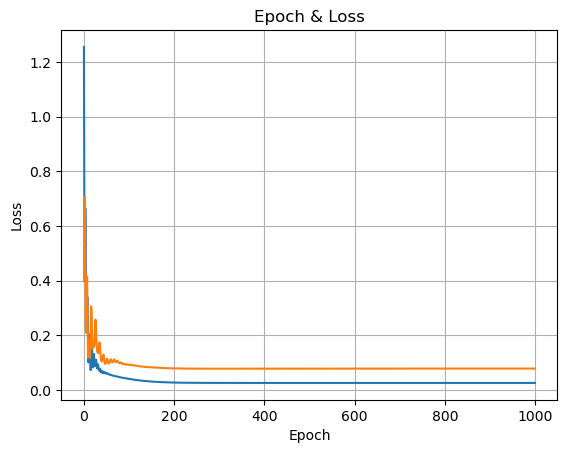

In [20]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

plt.plot(loss[0], label='Train')
plt.plot(loss[1], label='Test')
plt.title('Epoch & Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()